In [1]:
import numpy as np
import time
from copy import deepcopy
import batoid

%config InlineBackend.figure_format = 'retina' # increase quality but slower

In [2]:
def telescopeCreation():
    global WL
    global telescope, M1

    global outter1, inner1, outterD
    
    WL = 650e-9
    
    R1, conic1, inner1, outter1 = -16.256, -0.9953569, 1.38, 6.42
    #M1coord = defineCoordinate(anglX=0.0035, anglY=0.0035, anglZ=0, posX=200e-6, posY=200e-6, posZ=200e-6).local()
    M1coord = defineCoordinate().local()
    M1 = optic('M1',type='Quadric', RoC=R1, conic=conic1, inDiam=inner1, outDiam=outter1, coordSys=M1coord).mirrorWithSpider(width=0.3, height=4)
                                                                                                                             
    R2, conic2, outter2 = -1.660575, -1.566503, 0.7147252
    #M2coord = defineCoordinate(anglX=-0.00878, anglY=0.0116, anglZ=0, posX=-0.2014e-3, posY=0.8984e-3, posZ=-7.400+191.3e-6).local()
    M2coord = defineCoordinate(posZ=-7.400).local()
    M2 = optic('M2', type='Quadric', RoC=R2, conic=conic2, outDiam=outter2, coordSys=M2coord).mirror()

    R3, conic3, outter3 = -1.830517, -0.718069, 0.920733
    M3coord = defineCoordinate(posZ=+0.050).local()
    M3 = optic('M3', type='Quadric', RoC=R3, conic=conic3, outDiam=outter3, coordSys=M3coord).mirror()

    outter4 = 0.0991468
    M4coord = defineCoordinate(posZ=-0.983629).local()
    M4 = optic('M4', outDiam=outter4, coordSys=M4coord).flatMirror()

    outterD = 0.9
    Dcoord = defineCoordinate(posZ=0.237581).local()
    D = optic('D', outDiam=outterD, coordSys=Dcoord).detector()

    telescope = build.compoundOptic(M1, M2, M3, M4, D, 
                                    pupilSize=6.46, backDist=7.5,
                                    EPcoord=defineCoordinate(posZ=0).local())

In [3]:
def showLayout(show='2D'):
    start = time.time()

    ## Field bias + Number of rays per field`
    nbOfRaysPerField = 6 # should be even

    ## Rays of central field
    anglX, anglY = 0, 0
    anglY += fieldBias
    field0 = layout.rayBundle(telescope, WL, M1.inDiam, M1.outDiam, anglX, anglY, nbOfRaysPerField)

    ## Rays of central field 1
    anglX, anglY = 0, -0.043
    anglY += fieldBias
    field1 = layout.rayBundle(telescope, WL, M1.inDiam, M1.outDiam, anglX, anglY, nbOfRaysPerField)

    ## Rays of central field 2
    anglX, anglY = 0, 0.043
    anglY += fieldBias
    field2 = layout.rayBundle(telescope, WL, M1.inDiam, M1.outDiam, anglX, anglY, nbOfRaysPerField)

    ## Optic's lines
    opticsContours = layout.getAllLines(telescope)
    #opticsContours3D = deepcopy(opticsContours) ## important to make copy of the chain because it is nested (one use 'destroys' it)

    if show.casefold() == '2d':
        ## 2D visualization
        layout.visualized2D(len(field0), *opticsContours,
                            *field0, *field1, *field2)
    elif show.casefold() == '3d':
        ## 3D visualization
        layout.visualized3D(len(field0), *opticsContours,
                            *field0, *field1, *field2)
    
    print('2D and/or 3D calculation + plot time', np.round(time.time()-start, decimals=5), 's')

In [4]:
def showSpotDiagram(fieldX=0, fieldY=0):
    ## Incoming rays
    nbOfRays = 1e4
    fieldY += fieldBias
    rays0 = ray(telescope, fieldX=fieldX, fieldY=fieldY, wavelength=WL, nbOfRays=nbOfRays).fromPupil(type='grid')
    rays = rays0.copy()

    ## Trace rays + deleting vignetted ones
    telescope.trace(rays, reverse=False)
    rays = ray.deleteVignettedRays(rays)
    
    ## Some details
    infoTelescope = details(telescope, fieldX=fieldX, fieldY=fieldY, wavelength=WL)
    print('F/# in Image Space     :', np.round(infoTelescope.paraxialWorkingFNumber(), decimals=5), '      -> ZEMAX : 14.94606')
    print('Paraxial Working F/#   :', np.round(infoTelescope.FNumber(), decimals=5), '      -> ZEMAX : 14.94606')
    print('Working F/#            :', np.round(infoTelescope.workingFNumber(offFieldY=fieldBias), decimals=5), '      -> ZEMAX : 15.09287')
    print('NA in Image Space      :', np.round(infoTelescope.NA(), decimals=8), '    -> ZEMAX : 0.03343492')
    print('Effective Focal Length :', -np.round(infoTelescope.EFFL() * 1000, decimals=2), 'mm', '  -> ZEMAX : -96551.57 mm')
    print('XP position            :', np.round(batoid.analysis.exitPupilPos(optic=telescope, wavelength=WL)[-1]-telescope.items[-1].coordSys.origin[-1],
                                               decimals=6) * 1000, 'mm', '  -> ZEMAX : -1221.202 mm')
    print('Airy radius            :', np.round(airyR:=infoTelescope.airyRadius(offFieldY=fieldBias), decimals=4), 'µm', '    -> ZEMAX : 11.969 µm')
    print('Out/In Flux            :', np.round(np.sum(rays.flux)/np.sum(rays0.flux)*100, decimals=2), '%')
    print('Strehl Ratio           :', np.round(infoTelescope.strehlRatio(), decimals=4), '         -> ZEMAX : 0.991')

    ## Plot Spot Diagram
    plot.spotDiagram(rays0, fieldBias, rays, WL, airyR=airyR, scale=40)

In [11]:
def showWavefrontMap():
    fieldX, fieldY = 0, fieldBias

    ## Wavefront
    infoTelescope = details(telescope, fieldX=fieldX, fieldY=fieldY, wavelength=WL)
    WF = infoTelescope.wavefront(npx=1024, background=False)

    ## Wavefront details + Plot
    plot.wavefront(WF, WL, [fieldX, fieldY-fieldBias])

    ## Wavefront corrected + Plot
    corrWF, removed = correction.removeTiltWavefront(WF, WL, tiltX=False, tiltY=True)
    plot.wavefront(corrWF, WL, [fieldX, fieldY-fieldBias])
    print(f'Tilt Removed:  X = {np.round(removed[0], decimals=4)}, Y = {np.round(removed[1], decimals=4)} waves\n')

    
    ## Noll Zernike wavefront
    print('Zernikes :\n')
    Znk = infoTelescope.wavefrontZnk(npx=128, jmax=13, show=True)  #NB: show should be False for jmax > 13

In [6]:
def showPSF(show3D=False):  
    start = time.time()
    
    ## FFT PSF
    fieldX, fieldY = 0, fieldBias

    if show3D:
        pad = 2
    else:
        pad = 16
    
    infoTelescope = details(telescope, fieldX=fieldX, fieldY=fieldY, wavelength=WL)
    PSF, StehlRatio = infoTelescope.fftPSF(npx=128, pad=pad) # pad: pixelization / npx: accuracy

    ## PSF Plots
    if show3D:
        plot.psf3D(PSF, infoTelescope.airyRadius())
        print(f'Strehl Ratio : {StehlRatio:.3f}')
    else:
        plot.psf2D(PSF, infoTelescope.airyRadius())
        plot.psfCrossSection(PSF, infoTelescope.airyRadius(), WL, [fieldX, fieldY-fieldBias], StehlRatio, axis='X')


    print('\nPSF calculation+plot time', np.round(time.time()-start, decimals=5))

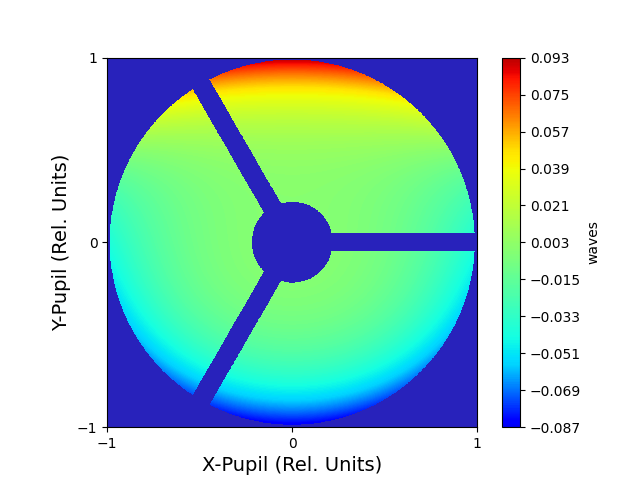

04/11/2024
0.65 µm at 0.0, 0.0 (deg)
Peak to valley = 0.18 waves, RMS = 0.0295 waves


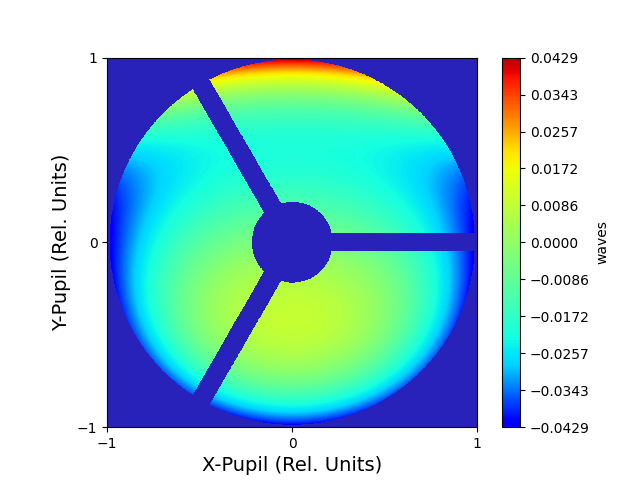

04/11/2024
0.65 µm at 0.0, 0.0 (deg)
Peak to valley = 0.0858 waves, RMS = 0.0143 waves
Tilt Removed:  X = 0.0, Y = 0.061 waves

Zernikes :

RMS (to chief)    :    0.010903483 (waves)

Z   1     -0.010524826  :      1
Z   2     -0.000000001  :      4^(1/2) (P) * COS (A)
Z   3      0.025370537  :      4^(1/2) (P) * SIN (A)
Z   4     -0.005585236  :      3^(1/2) (2P^2-1)
Z   5     -0.000000001  :      6^(1/2) (p^2) * SIN (2A)
Z   6     -0.007287371  :      6^(1/2) (p^2) * COS (2A)
Z   7      0.010179102  :      8^(1/2) (3p^3 - 2p) * SIN (A)
Z   8     -0.000000001  :      8^(1/2) (3p^3 - 2p) * COS (A)
Z   9     -0.003706387  :      8^(1/2) (p^3) * SIN (3A)
Z  10     -0.000000002  :      8^(1/2) (p^3) * COS (3A)
Z  11      0.000531321  :      5^(1/2) (6p^4-6p^2+1)
Z  12     -0.001385823  :      10^(1/2) (4p^4-3p^2) * COS (2A)
Z  13     -0.000000001  :      10^(1/2) (4p^4 - 3p^2) * SIN (2A)


In [18]:
def main():
    %run Batoid4LOFT.ipynb

    plt.close('all')

    global fieldBias
    fieldBias = 0.17
    
    telescopeCreation()

    ## Select what you want to see
    showWavefrontMap()
    #showLayout(show='2D')
    #showSpotDiagram(fieldX=0, fieldY=0)
    #showPSF(show3D=False)

if __name__=='__main__':
    main()